In [1]:
# deep learning libraries
import torch
import numpy as np

# other libraries
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# own modules
from src.train.utils import preprocess_imagenette, set_seed, load_cifar10_data, load_imagenette_data
from src.explain.saliency_maps import SaliencyMap, PositiveSaliencyMap, NegativeSaliencyMap, ActiveSaliencyMap, \
    InactiveSaliencyMap
from src.explain.benchmarks import deletion

# set seed
set_seed(42)
    
# set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# static variables
DATA_PATH = {'cifar10': './data/cifar10', 'imagenette': './data/imagenette/original_data'}
POSTPROCESS_DATA_PATH = {'cifar10': None, 'imagenette': './data/imagenette/postprocess_data'}
NUMBER_OF_CLASSES = 10

## Benchmark Deletion

In [6]:
def generate_graph(dataset: str, model_type: str, batch_size: int) -> None:
    # empty gpu
    torch.cuda.empty_cache()
    
    # hyperparameters
    lr = 1e-3
    pretrained = False
    epochs = 50

    if dataset == 'cifar10':
        _, val_data = load_cifar10_data(DATA_PATH[dataset], batch_size=batch_size)
    elif dataset == 'imagenette':
        # preprocess step
        if not os.path.isdir(POSTPROCESS_DATA_PATH[dataset]):
            preprocess_imagenette(DATA_PATH[dataset], POSTPROCESS_DATA_PATH[dataset])

        # load data
        _, val_data = load_imagenette_data(POSTPROCESS_DATA_PATH[dataset],  batch_size=batch_size)
        
    else:
        raise ValueError('Invalid dataset value')

    # define model name and tensorboard writer
    model_path = f'./models/{dataset}/{model_type}_pretrained_{pretrained}_lr_{lr}_epochs_{epochs}.pt'
    model = torch.load(model_path)

    methods = {'saliency map': SaliencyMap(model), 'positive saliency map': PositiveSaliencyMap(model), 
            'negative saliency map': NegativeSaliencyMap(model), 'active saliency map': ActiveSaliencyMap(model), 
            'inactive saliency map': InactiveSaliencyMap(model)}

    # initialize percentages
    percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    results = {}
    for method_name in list(methods.keys()):
        results[method_name] = deletion(val_data, methods[method_name], percentages)
        
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(percentages, np.transpose(np.array(list(results.values()))), marker='o')
    plt.xlabel('pixels deleted [%]')
    plt.ylabel('accuracy')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    plt.ylim([0, 1])
    plt.grid()
    plt.legend(list(results.keys()))
    plt.savefig(f'./visualizations/graphs/{dataset}/{model_type}_pretrained_{pretrained}_lr_{lr}_epochs_{epochs}.pdf', 
                bbox_inches='tight', pad_inches=0, format='pdf')
    plt.show()

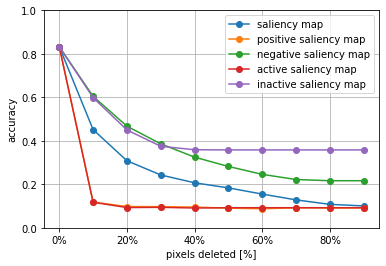

In [7]:
dataset = 'imagenette'
model_type = 'resnet18'
generate_graph(dataset, model_type, 128)

In [4]:
model = torch.load('./models/imagenette/resnet18_pretrained_False_lr_0.001_epochs_50.pt')
a = torch.ones(1, 3, 224, 224).to(device)
a[:, 0, :, :] =  0.46064087340445936
a[:, 1, :, :] = 0.45542655854304304
a[:, 2, :, :] = 0.4273219960606444
torch.sum(model(a))

tensor(-14.0741, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
dataset = 'imagenette'
model_type = 'efficientnet_v2'
generate_graph(dataset, model_type, 32)

Files already downloaded and verified
Files already downloaded and verified


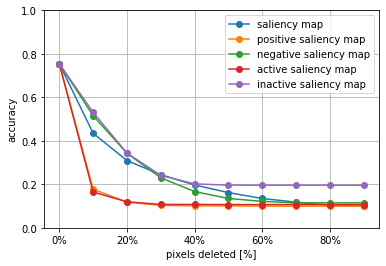

In [3]:
dataset = 'cifar10'
model_type = 'resnet18'
generate_graph(dataset, model_type, 128)

In [5]:
dataset = 'cifar10'
model_type = 'efficientnet_v2'
generate_graph(dataset, model_type, 128)

Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 